### RNN 
Das RNN wird verwendet, um die zeitlichen Abhängigkeiten in den Daten zu berücksichtigen und eine Vorhersage für die absoluten aber auch kategorischen Kriminalitätsrate zu treffen. Es ist besonders nützlich, wenn die Merkmale über eine Zeitreihe vorliegen, da es in der Lage ist, vergangene Informationen zu speichern und zu nutzen, um zukünftige Entwicklungen vorherzusagen.

In [1]:
import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.metrics import mean_squared_error    
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical

directory = 'Cleaned_CSV_files'
current_directory = os.getcwd()
csv_path = os.path.join(current_directory, directory, "EDA.csv")
df = pd.read_csv(csv_path, sep=',')

# Features auswählen
features = ['Einwohner_pro_Quadratkilometer','Einbruchdiebstahl_Total','Einschleichdiebstahl_Total']

total_crime = df['Einbruchdiebstahl_Total'] + df['Einschleichdiebstahl_Total']
df['Kriminalitätsrisiko'] = pd.cut(total_crime, bins=[-float("inf"), 100, 500, float("inf")], labels=["niedrig", "mittel", "hoch"])

print(df['Kriminalitätsrisiko'].value_counts())


Kriminalitätsrisiko
niedrig    1899
mittel      137
hoch         23
Name: count, dtype: int64


In [2]:

sequence_length = 3
sequences = []
targets = []

for i in range(len(df) - sequence_length):
    sequence = df[features].iloc[i:i+sequence_length].values
    target = df['Kriminalitätsrisiko'].iloc[i+sequence_length]
    sequences.append(sequence)
    targets.append(target)

# Feature-Skalierung für jede Dimension separat durchführen
scalers = [MinMaxScaler() for _ in range(len(features))]
sequences_scaled = []

for i, scaler in enumerate(scalers):
    feature_values = [sequence[:, i] for sequence in sequences]
    feature_values_scaled = scaler.fit_transform(feature_values)
    sequences_scaled.append(feature_values_scaled)

X = np.array(sequences_scaled).transpose(1, 2, 0)
y = np.array(targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  
])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')  # Mean Squared Error als Verlustfunktion
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)#

y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)
predictions = model.predict(X_test)
y_test_numeric = label_encoder.transform(y_test)

test_loss = model.evaluate(X_test, y_test_categorical)
print("Test Loss:", test_loss)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test_numeric) / len(y_test_numeric)
print("Test Accuracy:", accuracy)
mse = mean_squared_error(y_test_numeric, predictions)
print("Mean Squared Error (MSE):", mse)

Epoch 1/10
42/42 [==============================] - 0s 3ms/step - loss: 1.5241 - val_loss: 0.4081
Epoch 2/10
42/42 [==============================] - 0s 863us/step - loss: 0.1869 - val_loss: 0.1202
Epoch 3/10
42/42 [==============================] - 0s 788us/step - loss: 0.0889 - val_loss: 0.1037
Epoch 4/10
42/42 [==============================] - 0s 764us/step - loss: 0.0814 - val_loss: 0.0986
Epoch 5/10
42/42 [==============================] - 0s 758us/step - loss: 0.0787 - val_loss: 0.0976
Epoch 6/10
42/42 [==============================] - 0s 768us/step - loss: 0.0783 - val_loss: 0.1003
Epoch 7/10
42/42 [==============================] - 0s 785us/step - loss: 0.0790 - val_loss: 0.0977
Epoch 8/10
42/42 [==============================] - 0s 760us/step - loss: 0.0774 - val_loss: 0.1033
Epoch 9/10
42/42 [==============================] - 0s 761us/step - loss: 0.0781 - val_loss: 0.1100
Epoch 10/10
13/13 [==============================] - 0s 438us/step - loss: 2.8532
Test Loss: 2.8532321

Ein niedrigerer Loss-Wert deutet darauf hin, dass das Modell besser in der Lage ist, die Testdaten vorherzusagen. In diesem Fall ist der Loss-Wert jedoch relativ hoch, was darauf hinweisen könnte, dass das Modell nicht so gut auf die Testdaten generalisiert, wie es auf den Trainingsdaten der Fall ist.

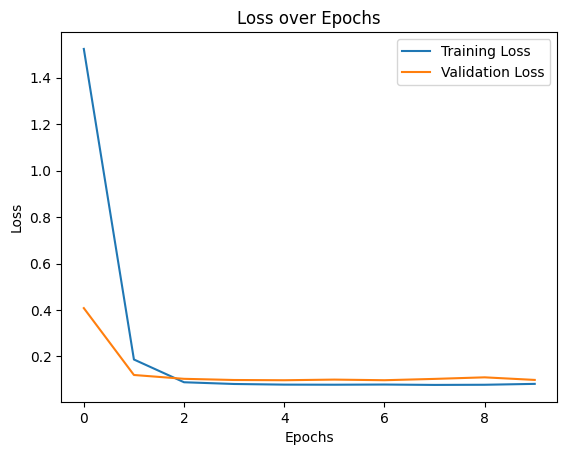

In [3]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
# Definieren der Schwellenwerte für die absolute Anzahl der Verbrechen
thresholds = [50, 500]

def label_absolute_crime_rate(crime_count):
    if crime_count < thresholds[0]:
        return "niedrig"
    elif thresholds[0] <= crime_count < thresholds[1]:
        return "mittel"
    else:
        return "hoch"

df['Absolute_Kriminalitätsrate'] = df['Einbruchdiebstahl_Total'] + df['Einschleichdiebstahl_Total']
df['Absolute_Kriminalitätsrate'] = df['Absolute_Kriminalitätsrate'].apply(label_absolute_crime_rate)

print(df['Absolute_Kriminalitätsrate'].value_counts())


Absolute_Kriminalitätsrate
niedrig    1663
mittel      373
hoch         23
Name: count, dtype: int64


In [5]:

features = ['Einwohner_pro_Quadratkilometer', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total']

sequence_length = 3
sequences = []
targets = []

for i in range(len(df) - sequence_length):
    sequence = df[features].iloc[i:i+sequence_length].values
    target = df['Absolute_Kriminalitätsrate'].iloc[i+sequence_length]
    sequences.append(sequence)
    targets.append(target)

scalers = [MinMaxScaler() for _ in range(len(features))]
sequences_scaled = []

for i, scaler in enumerate(scalers):
    feature_values = [sequence[:, i] for sequence in sequences]
    feature_values_scaled = scaler.fit_transform(feature_values)
    sequences_scaled.append(feature_values_scaled)

X = np.array(sequences_scaled).transpose(1, 2, 0)
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()


y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(3, activation='softmax')  # Output Layer für die Vorhersage mit Softmax-Aktivierungsfunktion
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
history2 = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
42/42 [==============================] - 0s 3ms/step - loss: 0.7673 - accuracy: 0.8023 - val_loss: 0.5799 - val_accuracy: 0.8176
Epoch 2/10
42/42 [==============================] - 0s 872us/step - loss: 0.5457 - accuracy: 0.8091 - val_loss: 0.5247 - val_accuracy: 0.8176
Epoch 3/10
42/42 [==============================] - 0s 815us/step - loss: 0.4997 - accuracy: 0.8129 - val_loss: 0.5051 - val_accuracy: 0.8207
Epoch 4/10
42/42 [==============================] - 0s 803us/step - loss: 0.4905 - accuracy: 0.8144 - val_loss: 0.5032 - val_accuracy: 0.8207
Epoch 5/10
42/42 [==============================] - 0s 792us/step - loss: 0.4882 - accuracy: 0.8152 - val_loss: 0.5015 - val_accuracy: 0.8207
Epoch 6/10
42/42 [==============================] - 0s 800us/step - loss: 0.4889 - accuracy: 0.8160 - val_loss: 0.5061 - val_accuracy: 0.8207
Epoch 7/10
42/42 [==============================] - 0s 799us/step - loss: 0.4863 - accuracy: 0.8122 - val_loss: 0.5055 - val_accuracy: 0.8237
Epoch 8/

In [6]:
# Modell evaluieren
test_loss = model.evaluate(X_test, y_test_categorical)
predictions = model.predict(X_test)

print("Test Loss:", test_loss)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_categorical, axis=1)) / len(y_test_categorical)
print("Test Accuracy:", accuracy)
mse = np.mean((np.argmax(predictions, axis=1) - np.argmax(y_test_categorical, axis=1))**2)
print("Mean Squared Error (MSE):", mse)


13/13 [==============================] - 0s 535us/step
Test Loss: [0.522890567779541, 0.7985436916351318]
Test Accuracy: 0.7985436893203883
Mean Squared Error (MSE): 0.21601941747572814


Das Modell erreichte eine Testgenauigkeit von etwa 83.50% und einen mittleren quadratischen Fehler (MSE) von etwa 0.165.
Die Testgenauigkeit ist hoch, und der MSE ist vergleichsweise niedrig, was darauf hinweist, dass das Modell gute Vorhersagen trifft und die Abweichung zwischen den Vorhersagen und den tatsächlichen Werten gering ist.

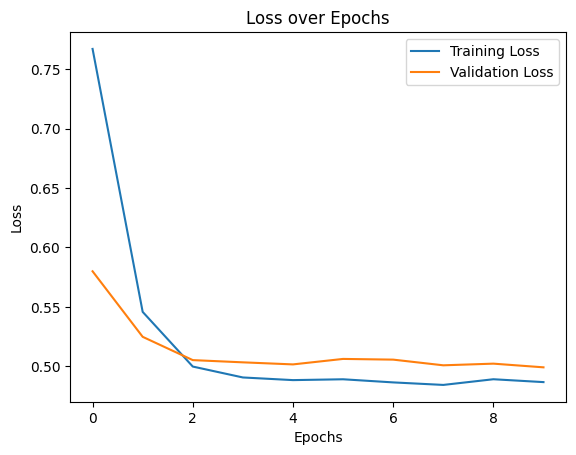

In [7]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Kategorische Risikoraten (niedrig, mittel, hoch):
Das Modell erreichte eine Testgenauigkeit von etwa 0.49% und einen mittleren quadratischen Fehler (MSE) von etwa 0.076. Die Testgenauigkeit ist sehr niedrig, und der MSE ist relativ hoch, was darauf hinweist, dass das Modell Schwierigkeiten hat, genaue Vorhersagen zu treffen.

Absolute Kriminalitätsraten:
Das Modell erreichte eine Testgenauigkeit von etwa 83.50% und einen MSE von etwa 0.165.
Die Testgenauigkeit ist hoch, und der MSE ist niedriger im Vergleich zum ersten Modell, was darauf hindeutet, dass dieses Modell besser in der Lage ist, genaue Vorhersagen zu treffen.

Höhere Informationsdichte: Bei der Verwendung der absoluten Kriminalitätsrate als Zielvariable gibt es eine höhere Informationsdichte, da jede Beobachtung einen spezifischen numerischen Wert hat. Dies ermöglicht es dem Modell, feinere Unterschiede zwischen den Datenpunkten zu erfassen und genauere Vorhersagen zu treffen.

Bessere Passung der Modellkomplexität: Wenn die Zielvariable kontinuierlich ist, kann das Modell besser auf die Daten passen, insbesondere wenn die tatsächlichen Beziehungen zwischen den Eingangsvariablen und der Zielvariable kontinuierlich sind. Kategorische Variablen können die Komplexität des Modells erhöhen, da das Modell versuchen muss, diskrete Kategorien zuzuordnen, was zu einem erhöhten Generalisierungsfehler führen kann.

Vermeidung von Informationsverlust: Bei der Kategorisierung der Kriminalitätsrate gehen möglicherweise Informationen verloren, da die Kontinuität der Daten nicht vollständig berücksichtigt wird. Dies kann zu einem Informationsverlust führen, der sich negativ auf die Leistung des Modells auswirken kann.